In [1]:
from ast import literal_eval
from scipy.spatial import distance
from joblib import Parallel, delayed, parallel_backend
import multiprocessing

In [2]:
def bits(n):
    b = []
    while n:
        b = [n & 1] + b
        n >>= 1
    if len(b) < 16:
        for i in range(16 - len(b)):
            b = [0] + b
    return b or [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [3]:
def get_geno_bits(geno,n_sample,num_reg):
    geno_bits = []
    
    for ind in range(n_sample):
        geno_bits.append([])
        for reg in range(num_reg):
            seq = bits(geno[ind * num_reg + reg])
            for bp in range(len(seq)):
                geno_bits[ind].append(seq[bp])
    
    return geno_bits
    

In [4]:
def get_otus(geno_bits,n_sample,num_reg):
    av_list = []
    for i in range(n_sample - 1):
        av_list.append(1 + i)
    
    otu = []
    
    rep = 0
    while(1):
        tmp = [[item for item in geno_bits[rep]]]
        rm = []
        for i in range(len(av_list)):
            num_diff = distance.cityblock(geno_bits[rep],geno_bits[av_list[i]])
                
            if num_diff/(num_reg * 15) < 0.03:
                tmp.append([item for item in geno_bits[av_list[i]]])
                rm.append(av_list[i])
                
        otu.append([[item for item in sublist] for sublist in tmp])
        
        tmp_av_list = []
        for i in range(len(av_list)):
            check = 0
            for j in range(len(rm)):
                if av_list[i] == rm[j]:
                    check = 1
            if check == 0:
                tmp_av_list.append(av_list[i])
        av_list = [tmp_av_list[i] for i in range(len(tmp_av_list))]
        if len(av_list) == 0:
            break
        rep = min(av_list)
        av_list.remove(rep)
    
    rm_otu = []
    for i in range(len(otu)):
        if len(otu[i]) <= 1:
            rm_otu.append(otu[i])
    
    for i in range(len(rm_otu)):
        otu.remove(rm_otu[i])
    
    loc_S_list = []
    loc_th_list = []
    loc_n_list = []
    loc_D_list = []
    
    for cls in range(len(otu)):
        dist = []
        bp_sum = [0 for i in range(num_reg * 16)]
        for bp in range(num_reg * 16):
            bp_sum[bp] = bp_sum[bp] + otu[cls][len(otu[cls]) - 1][bp]
        for ind1 in range(len(otu[cls]) - 1):
            for indx in range(len(otu[cls]) - (ind1 + 1)):
                ind2 = ind1 + indx + 1
                dist.append(distance.cityblock(otu[cls][ind1],otu[cls][ind2]))
            for bp in range(len(otu[cls][ind1])):
                bp_sum[bp] = bp_sum[bp] + otu[cls][ind1][bp]
        
        n = len(otu[cls])
        
        k = sum(dist)/len(dist)
        
        S = 0
        for bp in range(num_reg * 16):
            if bp_sum[bp] > 0 and bp_sum[bp] < n:
                S = S + 1
        
        a1 = 0
        a2 = 0
        for i in range(n - 1):
            a1 = a1 + 1/(i+1)
            a2 = a2 + 1/((i+1)**2)
        
        b1 = (n + 1)/(3*(n - 1))
        b2 = (2*(n**2 + n + 3))/(9*n*(n - 1))
        c1 = b1 - 1/a1
        c2 = b2 - (n+2)/(a1*n) + a2/(a1**2)
        e1 = c1/a1
        e2 = c2/(a1**2 + a2)
        
        if (e1*S + e2*S*(S - 1)) > 0:
            d = (k - S/a1)/((e1*S + e2*S*(S - 1))**0.5)
        else:
            d = 0
        
        loc_S_list.append(S)
        loc_th_list.append(k)
        loc_D_list.append(d)
    
    loc_n_list = [len(otu[i]) for i in range(len(otu))]
    
    return [loc_n_list,loc_S_list,loc_th_list,loc_D_list]

In [5]:
geno=[]
with open('Geno.out','r') as data_file: 
    for line in data_file: 
       geno.append(literal_eval(line))
data_file.close()

In [6]:
# Check that genotypes are okay, such that max < 2^16 = 65536
max([max(geno[i]) for i in range(len(geno))])

64592

In [7]:
len(geno)

100

In [8]:
num_reps = len(geno)
num_reg = 100
n_sample = 1000

num_cores = 12

In [9]:
with parallel_backend("loky", inner_max_num_threads=1):
    geno_bits = Parallel(n_jobs=num_cores)(delayed(get_geno_bits)(geno[i],n_sample,num_reg) for i in range(len(geno)))

In [10]:
with parallel_backend("loky", inner_max_num_threads=1):
    otu_res = Parallel(n_jobs=num_cores)(delayed(get_otus)(geno_bits[i],n_sample,num_reg) for i in range(len(geno_bits)))

In [13]:
n_list = [[item for item in otu_res[i][0]] for i in range(len(otu_res))]
S_list = [[item for item in otu_res[i][1]] for i in range(len(otu_res))]
pi_list = [[item for item in otu_res[i][2]] for i in range(len(otu_res))]
D_list = [[item for item in otu_res[i][3]] for i in range(len(otu_res))]

In [14]:
import matplotlib.pyplot as plt
import math as m

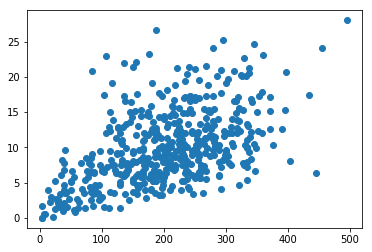

In [15]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

plt.scatter(n_plot,pi_plot)
plt.show()

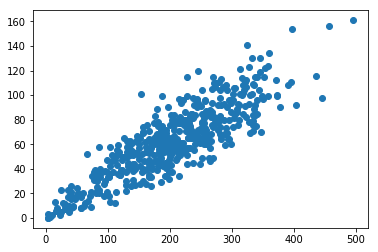

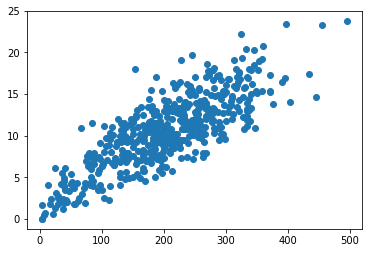

In [16]:
n_plot = [item for sublist in n_list for item in sublist]
a1 = [sum([1/(i + 1) for i in range(item - 1)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]


plt.scatter(n_plot,S_raw)
plt.show()

plt.scatter(n_plot,S_plot)
plt.show()

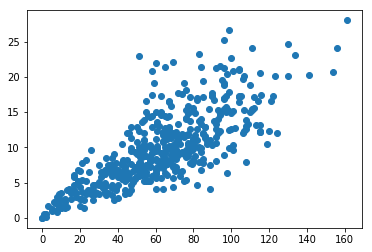

In [17]:
S_plot = [item for sublist in S_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

plt.scatter(S_plot,pi_plot)
plt.show()

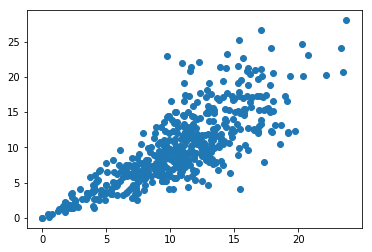

In [18]:
a1 = [sum([1/(i + 1) for i in range(item - 1)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]

pi_plot = [item for sublist in pi_list for item in sublist]

plt.scatter(S_plot,pi_plot)
plt.show()

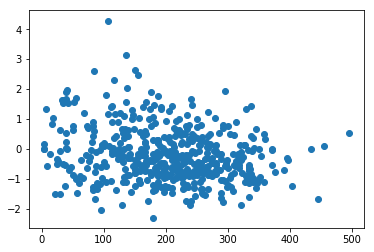

In [19]:
n_plot = [item for sublist in n_list for item in sublist]
D_plot = [item for sublist in D_list for item in sublist]

plt.scatter(n_plot,D_plot)
plt.show()

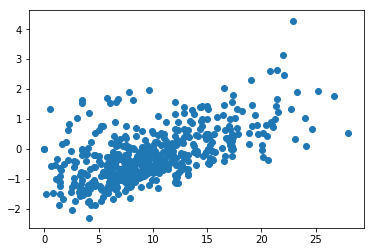

In [20]:
pi_plot = [item for sublist in pi_list for item in sublist]
D_plot = [item for sublist in D_list for item in sublist]

plt.scatter(pi_plot,D_plot)
plt.show()

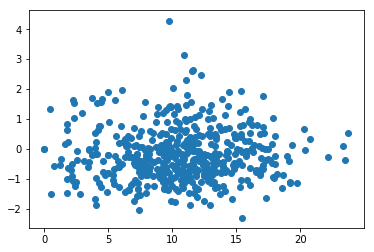

In [21]:
a1 = [sum([1/(i + 1) for i in range(item - 1)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]

D_plot = [item for sublist in D_list for item in sublist]

plt.scatter(S_plot,D_plot)
plt.show()

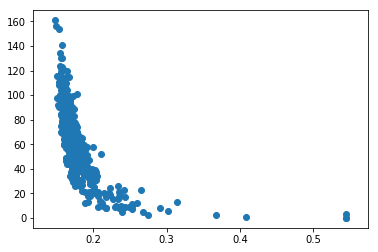

In [22]:
a1 = [1/sum([1/(i + 1) for i in range(item - 1)]) for sublist in n_list for item in sublist]
S_plot = [item for sublist in S_list for item in sublist]

plt.scatter(a1,S_plot)
plt.show()

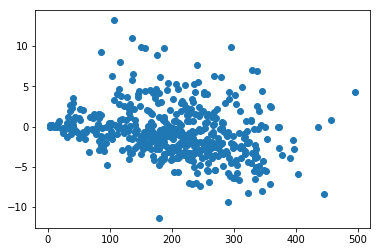

In [23]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

a1 = [sum([1/(i + 1) for i in range(item - 0)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]

piS_plot = [(pi_plot[i] - S_plot[i]) for i in range(len(S_plot))]

plt.scatter(n_plot,piS_plot)
plt.show()

In [24]:
bins = [i*50 for i in range(11)]

piS_bins = [[] for i in range(len(bins))]
for i in range(len(n_plot)):
    for j in [k + 1 for k in range(len(bins) - 1)]:
        if n_plot[i] > bins[j - 1] and n_plot[i] <= bins[j]:
            piS_bins[j].append(piS_plot[i])

m_piS_bins = []
for j in range(len(piS_bins)):
    if len(piS_bins[j]) > 0:
        m_piS_bins.append(sum(piS_bins[j])/len(piS_bins[j]))
    else:
        m_piS_bins.append(0)
    

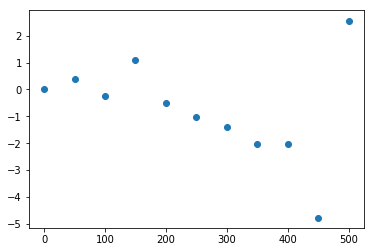

In [25]:
plt.scatter(bins,m_piS_bins)
plt.show()

Expected abundances from Broken Stick model of MacArthur '57

In [26]:
def broken_stick(n_sp,n_sample):
    return [sum([1/(n_sp - (j + 1) + 1) for j in range(i + 1)])/n_sp * n_sample for i in range(n_sp)]

In [27]:
broken_stick(8,1000)

[15.625,
 33.482142857142854,
 54.31547619047619,
 79.31547619047619,
 110.56547619047619,
 152.23214285714283,
 214.73214285714283,
 339.73214285714283]

In [28]:
max([len(n_list[i]) for i in range(len(n_list))])

7

In [31]:
comp_n_list = [[],[],[],[],[],[],[]]
for i in range(len(n_list)):
    comp_n_list[len(n_list[i]) - 1 - 0].append([item for item in n_list[i]])

In [62]:
n_otu = 6

len(comp_n_list[n_otu - 1])

21

In [63]:
lst = [[item for item in sublist] for sublist in comp_n_list[n_otu - 1]]

m_list = [0 for i in range(len(lst[0]))]

for i in range(len(lst)):
    lst[i].sort()
    for j in range(len(m_list)):
        m_list[j] = m_list[j] + lst[i][j]/len(lst)

In [64]:
m_list

[58.904761904761905,
 109.0,
 146.28571428571428,
 182.42857142857144,
 215.19047619047618,
 288.1904761904762]

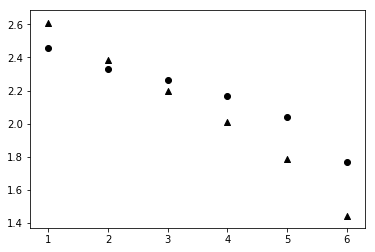

In [65]:
x_plot = [i+1 for i in range(len(m_list))]
br_stk_exp = broken_stick(n_otu,1000)
m_list = [m.log10(m_list[len(m_list) - i - 1]) for i in range(len(m_list))]
br_stk_exp = [m.log10(br_stk_exp[len(br_stk_exp) - i - 1]) for i in range(len(br_stk_exp))]

plt.scatter(x_plot,br_stk_exp,color='k',marker="^")
plt.scatter(x_plot,m_list,color='k')

plt.savefig('SAD_6.eps',format='eps',dpi=600)

In [66]:
n_list

[[180, 184, 245, 162, 131, 98],
 [237, 241, 258, 74, 176, 14],
 [287, 286, 156, 271],
 [167, 254, 188, 310, 81],
 [248, 333, 118, 301],
 [181, 225, 200, 191, 203],
 [269, 82, 176, 157, 215, 101],
 [191, 197, 296, 227, 89],
 [337, 250, 188, 36, 189],
 [77, 144, 281, 184, 140, 174],
 [232, 273, 495],
 [281, 132, 377, 210],
 [272, 280, 290, 158],
 [179, 337, 179, 305],
 [179, 166, 305, 123, 90, 137],
 [258, 181, 206, 141, 214],
 [185, 282, 233, 147, 116, 37],
 [265, 341, 57, 252, 85],
 [94, 234, 318, 354],
 [203, 201, 334, 139, 88, 35],
 [174, 289, 114, 155, 268],
 [150, 79, 129, 198, 258, 186],
 [170, 347, 256, 227],
 [298, 136, 168, 210, 188],
 [214, 372, 255, 143, 16],
 [332, 346, 185, 133, 4],
 [338, 203, 137, 270, 51],
 [397, 234, 334, 35],
 [204, 210, 206, 238, 142],
 [226, 318, 135, 221, 100],
 [293, 218, 82, 96, 82, 229],
 [188, 179, 264, 243, 126],
 [219, 78, 334, 218, 151],
 [233, 43, 352, 372],
 [235, 212, 145, 258, 150],
 [169, 290, 313, 40, 188],
 [257, 266, 252, 225],
 [371,

In [67]:
S_list

[[42, 48, 94, 28, 50, 21],
 [81, 60, 60, 34, 83, 13],
 [93, 107, 69, 110],
 [44, 74, 75, 93, 20],
 [44, 130, 54, 101],
 [75, 78, 76, 54, 37],
 [49, 37, 46, 30, 77, 18],
 [66, 42, 96, 57, 37],
 [115, 91, 58, 23, 58],
 [37, 27, 82, 45, 31, 51],
 [57, 107, 161],
 [68, 54, 90, 79],
 [80, 104, 108, 46],
 [60, 84, 39, 106],
 [89, 71, 85, 39, 37, 55],
 [69, 78, 72, 42, 52],
 [72, 64, 75, 52, 36, 5],
 [57, 115, 8, 71, 38],
 [28, 69, 108, 122],
 [53, 65, 71, 61, 33, 17],
 [60, 68, 55, 37, 94],
 [65, 39, 27, 53, 72, 52],
 [61, 70, 68, 76],
 [86, 60, 54, 78, 67],
 [77, 100, 69, 40, 6],
 [101, 119, 43, 42, 3],
 [92, 55, 26, 115, 19],
 [154, 85, 109, 9],
 [80, 47, 77, 98, 44],
 [71, 85, 41, 61, 33],
 [64, 57, 25, 30, 33, 65],
 [99, 64, 46, 97, 65],
 [57, 31, 79, 56, 65],
 [83, 10, 115, 99],
 [85, 64, 63, 87, 57],
 [33, 73, 101, 17, 55],
 [96, 82, 77, 80],
 [112, 107, 41, 47],
 [130, 74, 63, 96, 0],
 [108, 61, 58, 28, 62, 2],
 [54, 90, 71, 76],
 [59, 83, 45, 76, 10],
 [44, 51, 78, 54, 37, 40],
 [104

In [68]:
pi_list

[[6.272873991309745,
  6.585768591114279,
  14.894212111073937,
  4.625795567824554,
  10.7936582501468,
  2.721859877971807],
 [14.918758492455124,
  4.1163900414937755,
  6.427713932374144,
  8.497963717141799,
  23.27357142857143,
  3.901098901098901],
 [14.036158962988232,
  20.13838792786161,
  22.055665839536807,
  18.835369687030205],
 [5.802467354447731,
  11.879960163082382,
  9.269769029468653,
  12.100803841737134,
  4.327160493827161],
 [3.330286012798746,
  20.099677991244256,
  13.832101984644357,
  9.655415282392026],
 [19.133578882750154,
  13.702619047619047,
  8.93572864321608,
  8.793496831082942,
  6.976735111934839],
 [5.537479886811297,
  8.464016862390846,
  5.648181818181818,
  3.4492895639392454,
  14.833644859813084,
  2.927128712871287],
 [11.751116009920088,
  6.062364031907179,
  25.253137883646357,
  10.209270593739035,
  4.685903983656793],
 [20.49282888229476,
  16.786859437751005,
  5.886790306064398,
  8.198412698412698,
  9.232804232804233],
 [6.58373

In [69]:
D_list

[[-0.4100144733150147,
  -0.6139864261731117,
  -0.11304651589863104,
  -0.18521945531980394,
  0.5446935491445993,
  -0.9689573164719479],
 [0.34192006391767893,
  -1.7330875702303212,
  -1.013388455294417,
  0.6968951484592589,
  1.8951185075080785,
  -0.18360364037018814],
 [-0.17707491347199666,
  0.52227227057485,
  2.476367221722926,
  0.17548431087675215],
 [-0.7456586534435728,
  -0.05593774403886567,
  -0.8647991012733601,
  -0.5334864874557009,
  0.2210982535173765],
 [-1.556995641243894,
  -0.03909097313429889,
  1.1579607091853217,
  -1.1995636652996942],
 [1.4555776376972267,
  0.15907160238058782,
  -0.945624636985344,
  -0.15352696402620278,
  0.3186719956011287],
 [-0.8764984497543559,
  0.44048012098357303,
  -0.8800096364127754,
  -1.0218310484512652,
  0.4419122494078973,
  -0.44540316321037726],
 [0.11396717062181817,
  -0.45315501118995977,
  1.9448474336578774,
  0.22173153242165275,
  -1.1295908597714175],
 [0.41869106161697633,
  0.3777190867814629,
  -1.2394139

In [70]:
sum([len(n_list[i]) for i in range(len(n_list))])/len(n_list)

4.93

In [71]:
from statistics import mean
from random import choices

In [72]:
data = [len(n_list[i]) for i in range(len(n_list))]

In [73]:
means = sorted(mean(choices(data, k=len(data))) for i in range(1000))

In [74]:
print(f'The sample mean of {mean(data):.5f} has a 95% confidence '
      f'interval from {means[24]:.5f} to {means[974]:.5f}')

The sample mean of 4.93000 has a 95% confidence interval from 4.78000 to 5.08000


In [75]:
import matplotlib.pyplot as plt
import math as m

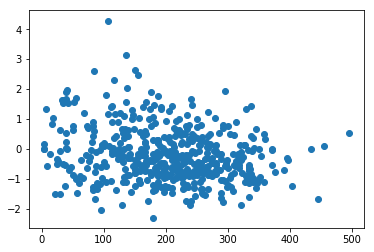

In [76]:
n_plot = [item for sublist in n_list for item in sublist]
D_plot = [item for sublist in D_list for item in sublist]

plt.scatter(n_plot,D_plot)
plt.show()

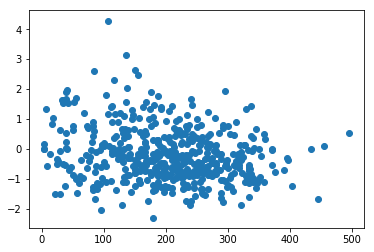

In [77]:
n_plot = [item for sublist in n_list for item in sublist]
D_plot = [item for sublist in D_list for item in sublist]


plt.scatter(n_plot,D_plot)
plt.savefig('D_vs_n.eps',format='eps',dpi=600)

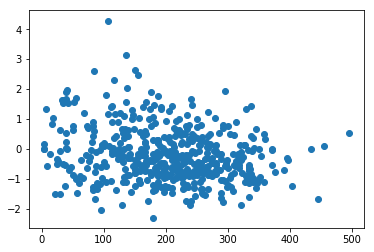

In [78]:
n_plot = [item for sublist in n_list for item in sublist]
D_plot = [item for sublist in D_list for item in sublist]


plt.scatter(n_plot,D_plot)
plt.savefig('D_vs_n.tiff',format='tiff',dpi=600)

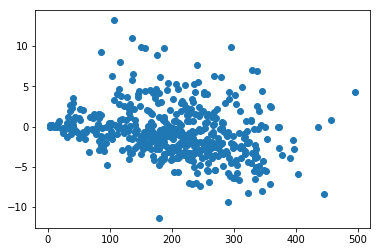

In [79]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

a1 = [sum([1/(i + 1) for i in range(item - 0)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]

piS_plot = [(pi_plot[i] - S_plot[i]) for i in range(len(S_plot))]

plt.scatter(n_plot,piS_plot)
plt.show()

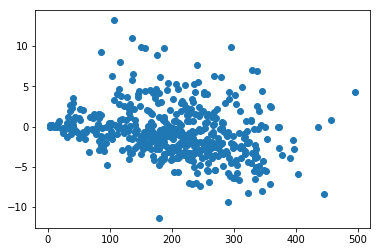

In [80]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

a1 = [sum([1/(i + 1) for i in range(item - 0)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]

piS_plot = [(pi_plot[i] - S_plot[i]) for i in range(len(S_plot))]

plt.scatter(n_plot,piS_plot)

plt.savefig('D-S_vs_n.tiff',format='tiff',dpi=600)

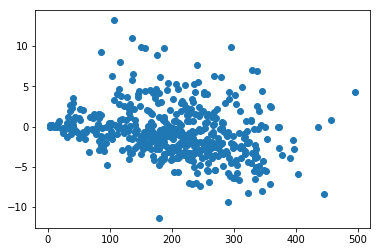

In [81]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

a1 = [sum([1/(i + 1) for i in range(item - 0)]) for sublist in n_list for item in sublist]
S_raw = [item for sublist in S_list for item in sublist]
S_plot = [S_raw[i]/a1[i] for i in range(len(a1))]

piS_plot = [(pi_plot[i] - S_plot[i]) for i in range(len(S_plot))]

plt.scatter(n_plot,piS_plot)

plt.savefig('D-S_vs_n.eps',format='eps',dpi=600)

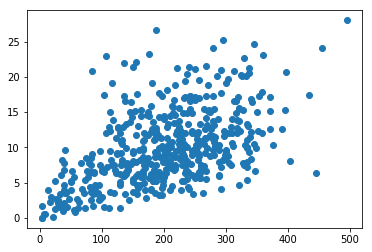

In [82]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

plt.scatter(n_plot,pi_plot)
plt.show()

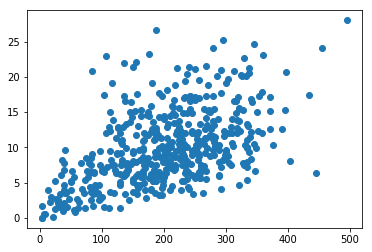

In [83]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

plt.scatter(n_plot,pi_plot)

plt.savefig('pi_vs_n.eps',format='eps',dpi=600)

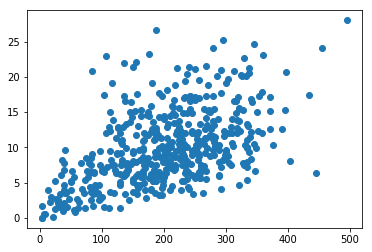

In [84]:
n_plot = [item for sublist in n_list for item in sublist]
pi_plot = [item for sublist in pi_list for item in sublist]

plt.scatter(n_plot,pi_plot)

plt.savefig('pi_vs_n.tiff',format='tiff',dpi=600)

In [4]:
from scipy import stats
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [5]:
pi_plot = []
S_raw = []

n_plot = []

for i in range(len(pi_list)):
    for j in range(len(pi_list[i])):
        if S_list[i][j] > 0:
            a1 = sum([1/(k + 1) for k in range(n_list[i][j] - 0)])
            pi_plot.append(m.log(pi_list[i][j]))
            S_raw.append(m.log(S_list[i][j]/a1))
            n_plot.append(n_list[i][j])

In [6]:
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(pi_plot),np.array(S_raw))

In [7]:
[slope,intercept,r_value**2,p_value,std_err]

[0.7444427904854418,
 0.6634129311442853,
 0.7635314020412635,
 3.1841361064890784e-155,
 0.018734848497164443]

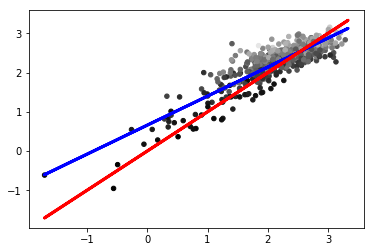

In [9]:
plt.scatter(pi_plot,S_raw,s=20,c=n_plot,cmap='gray')

y_exp = [0.66 + 0.74 * pi_plot[i] for i in range(len(pi_plot))]
plt.plot(np.array(pi_plot).reshape(-1,1), np.array(y_exp), color='blue', linewidth=3)

y_exp = [0 + 1.0 * pi_plot[i] for i in range(len(pi_plot))]
plt.plot(np.array(pi_plot).reshape(-1,1), np.array(y_exp), color='red', linewidth=3)

plt.show()

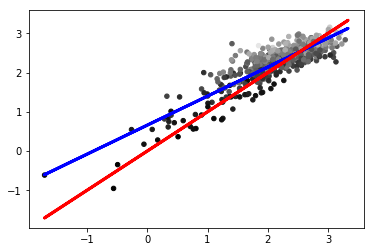

In [10]:
plt.scatter(pi_plot,S_raw,s=20,c=n_plot,cmap='gray')

y_exp = [0.66 + 0.74 * pi_plot[i] for i in range(len(pi_plot))]
plt.plot(np.array(pi_plot).reshape(-1,1), np.array(y_exp), color='blue', linewidth=3)

y_exp = [0 + 1.0 * pi_plot[i] for i in range(len(pi_plot))]
plt.plot(np.array(pi_plot).reshape(-1,1), np.array(y_exp), color='red', linewidth=3)

plt.savefig('Sda1-v-pi.eps',format='eps',dpi=600)

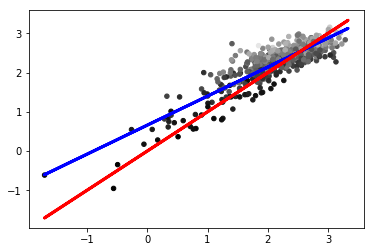

In [11]:
plt.scatter(pi_plot,S_raw,s=20,c=n_plot,cmap='gray')

y_exp = [0.66 + 0.74 * pi_plot[i] for i in range(len(pi_plot))]
plt.plot(np.array(pi_plot).reshape(-1,1), np.array(y_exp), color='blue', linewidth=3)

y_exp = [0 + 1.0 * pi_plot[i] for i in range(len(pi_plot))]
plt.plot(np.array(pi_plot).reshape(-1,1), np.array(y_exp), color='red', linewidth=3)

plt.savefig('Sda1-v-pi.tiff',format='tiff',dpi=600)

In [1]:
n_list = [[180, 184, 245, 162, 131, 98],
 [237, 241, 258, 74, 176, 14],
 [287, 286, 156, 271],
 [167, 254, 188, 310, 81],
 [248, 333, 118, 301],
 [181, 225, 200, 191, 203],
 [269, 82, 176, 157, 215, 101],
 [191, 197, 296, 227, 89],
 [337, 250, 188, 36, 189],
 [77, 144, 281, 184, 140, 174],
 [232, 273, 495],
 [281, 132, 377, 210],
 [272, 280, 290, 158],
 [179, 337, 179, 305],
 [179, 166, 305, 123, 90, 137],
 [258, 181, 206, 141, 214],
 [185, 282, 233, 147, 116, 37],
 [265, 341, 57, 252, 85],
 [94, 234, 318, 354],
 [203, 201, 334, 139, 88, 35],
 [174, 289, 114, 155, 268],
 [150, 79, 129, 198, 258, 186],
 [170, 347, 256, 227],
 [298, 136, 168, 210, 188],
 [214, 372, 255, 143, 16],
 [332, 346, 185, 133, 4],
 [338, 203, 137, 270, 51],
 [397, 234, 334, 35],
 [204, 210, 206, 238, 142],
 [226, 318, 135, 221, 100],
 [293, 218, 82, 96, 82, 229],
 [188, 179, 264, 243, 126],
 [219, 78, 334, 218, 151],
 [233, 43, 352, 372],
 [235, 212, 145, 258, 150],
 [169, 290, 313, 40, 188],
 [257, 266, 252, 225],
 [371, 323, 194, 112],
 [345, 301, 131, 219, 4],
 [336, 183, 162, 151, 159, 9],
 [213, 197, 256, 334],
 [207, 270, 238, 223, 62],
 [228, 136, 251, 130, 98, 157],
 [343, 195, 239, 198, 25],
 [199, 73, 22, 171, 267, 268],
 [230, 243, 360, 47, 120],
 [257, 149, 275, 279, 40],
 [221, 282, 456, 41],
 [140, 312, 435, 113],
 [268, 236, 257, 199, 40],
 [246, 245, 189, 320],
 [112, 86, 275, 278, 141, 108],
 [150, 233, 322, 295],
 [231, 60, 123, 265, 321],
 [299, 193, 258, 30, 220],
 [237, 96, 68, 339, 260],
 [156, 311, 241, 292],
 [335, 207, 299, 107, 52],
 [318, 287, 229, 166],
 [187, 227, 313, 167, 56, 50],
 [229, 446, 325],
 [255, 283, 38, 206, 218],
 [107, 358, 183, 193, 132, 27],
 [317, 154, 224, 261, 44],
 [327, 169, 73, 214, 217],
 [292, 234, 179, 207, 88],
 [404, 66, 243, 167, 120],
 [358, 251, 309, 82],
 [198, 150, 310, 102, 184, 56],
 [245, 192, 151, 214, 198],
 [253, 242, 206, 281, 18],
 [328, 224, 261, 187],
 [216, 298, 251, 194, 41],
 [187, 269, 252, 292],
 [255, 283, 161, 301],
 [328, 220, 200, 83, 169],
 [104, 350, 235, 208, 103],
 [201, 391, 279, 125, 4],
 [395, 146, 163, 296],
 [289, 303, 233, 175],
 [335, 115, 277, 104, 169],
 [321, 239, 199, 201, 40],
 [192, 212, 274, 188, 134],
 [219, 265, 248, 268],
 [231, 237, 216, 192, 124],
 [226, 255, 280, 200, 39],
 [322, 159, 129, 182, 114, 94],
 [329, 244, 186, 114, 127],
 [237, 225, 98, 157, 173, 86, 24],
 [85, 317, 250, 186, 7, 155],
 [334, 308, 131, 227],
 [245, 330, 174, 180, 71],
 [164, 349, 341, 116, 30],
 [239, 163, 140, 129, 266, 63],
 [257, 186, 280, 141, 136],
 [229, 290, 216, 215, 50],
 [228, 166, 304, 170, 132],
 [234, 341, 211, 182, 32],
 [210, 166, 263, 210, 121, 30],
 [147, 201, 101, 129, 177, 245]]

In [2]:
S_list = [[42, 48, 94, 28, 50, 21],
 [81, 60, 60, 34, 83, 13],
 [93, 107, 69, 110],
 [44, 74, 75, 93, 20],
 [44, 130, 54, 101],
 [75, 78, 76, 54, 37],
 [49, 37, 46, 30, 77, 18],
 [66, 42, 96, 57, 37],
 [115, 91, 58, 23, 58],
 [37, 27, 82, 45, 31, 51],
 [57, 107, 161],
 [68, 54, 90, 79],
 [80, 104, 108, 46],
 [60, 84, 39, 106],
 [89, 71, 85, 39, 37, 55],
 [69, 78, 72, 42, 52],
 [72, 64, 75, 52, 36, 5],
 [57, 115, 8, 71, 38],
 [28, 69, 108, 122],
 [53, 65, 71, 61, 33, 17],
 [60, 68, 55, 37, 94],
 [65, 39, 27, 53, 72, 52],
 [61, 70, 68, 76],
 [86, 60, 54, 78, 67],
 [77, 100, 69, 40, 6],
 [101, 119, 43, 42, 3],
 [92, 55, 26, 115, 19],
 [154, 85, 109, 9],
 [80, 47, 77, 98, 44],
 [71, 85, 41, 61, 33],
 [64, 57, 25, 30, 33, 65],
 [99, 64, 46, 97, 65],
 [57, 31, 79, 56, 65],
 [83, 10, 115, 99],
 [85, 64, 63, 87, 57],
 [33, 73, 101, 17, 55],
 [96, 82, 77, 80],
 [112, 107, 41, 47],
 [130, 74, 63, 96, 0],
 [108, 61, 58, 28, 62, 2],
 [54, 90, 71, 76],
 [59, 83, 45, 76, 10],
 [44, 51, 78, 54, 37, 40],
 [104, 66, 69, 61, 23],
 [47, 9, 2, 40, 63, 76],
 [80, 96, 134, 15, 35],
 [73, 66, 77, 79, 21],
 [96, 113, 156, 26],
 [54, 80, 116, 21],
 [86, 71, 95, 62, 8],
 [72, 64, 42, 104],
 [12, 23, 81, 72, 51, 37],
 [60, 73, 82, 64],
 [75, 20, 47, 87, 91],
 [60, 72, 63, 7, 78],
 [66, 38, 14, 75, 84],
 [70, 92, 84, 90],
 [89, 57, 96, 46, 20],
 [102, 80, 65, 47],
 [55, 51, 121, 35, 17, 19],
 [70, 98, 141],
 [81, 67, 10, 76, 94],
 [51, 99, 54, 61, 62, 12],
 [114, 101, 54, 64, 9],
 [123, 57, 21, 34, 60],
 [104, 65, 68, 84, 40],
 [92, 52, 90, 53, 35],
 [124, 49, 89, 22],
 [32, 48, 76, 34, 51, 8],
 [66, 45, 42, 71, 37],
 [66, 67, 67, 98, 8],
 [93, 80, 60, 64],
 [82, 94, 104, 69, 15],
 [67, 74, 85, 69],
 [77, 92, 54, 96],
 [78, 77, 59, 30, 42],
 [42, 97, 65, 63, 13],
 [84, 108, 111, 50, 0],
 [111, 53, 40, 80],
 [59, 106, 82, 65],
 [83, 43, 92, 58, 45],
 [111, 55, 55, 52, 17],
 [34, 57, 110, 44, 58],
 [61, 88, 61, 105],
 [77, 65, 51, 57, 50],
 [76, 60, 83, 50, 19],
 [112, 39, 22, 45, 51, 18],
 [100, 66, 29, 51, 50],
 [67, 86, 47, 74, 63, 20, 5],
 [58, 100, 73, 49, 1, 52],
 [84, 86, 58, 99],
 [120, 69, 77, 47, 18],
 [56, 99, 85, 59, 11],
 [92, 76, 38, 37, 68, 12],
 [64, 60, 74, 44, 63],
 [57, 69, 61, 97, 24],
 [115, 33, 81, 26, 45],
 [70, 96, 49, 56, 9],
 [58, 64, 49, 61, 39, 10],
 [67, 43, 33, 30, 67, 70]]

In [3]:
pi_list = [[6.272873991309745,
  6.585768591114279,
  14.894212111073937,
  4.625795567824554,
  10.7936582501468,
  2.721859877971807],
 [14.918758492455124,
  4.1163900414937755,
  6.427713932374144,
  8.497963717141799,
  23.27357142857143,
  3.901098901098901],
 [14.036158962988232,
  20.13838792786161,
  22.055665839536807,
  18.835369687030205],
 [5.802467354447731,
  11.879960163082382,
  9.269769029468653,
  12.100803841737134,
  4.327160493827161],
 [3.330286012798746,
  20.099677991244256,
  13.832101984644357,
  9.655415282392026],
 [19.133578882750154,
  13.702619047619047,
  8.93572864321608,
  8.793496831082942,
  6.976735111934839],
 [5.537479886811297,
  8.464016862390846,
  5.648181818181818,
  3.4492895639392454,
  14.833644859813084,
  2.927128712871287],
 [11.751116009920088,
  6.062364031907179,
  25.253137883646357,
  10.209270593739035,
  4.685903983656793],
 [20.49282888229476,
  16.786859437751005,
  5.886790306064398,
  8.198412698412698,
  9.232804232804233],
 [6.583732057416268,
  2.461732711732712,
  11.077173360447382,
  6.071929199334759,
  6.4710174717368965,
  7.835758421367351],
 [8.842028660994178, 15.240627020038785, 28.03407352881037],
 [8.92526690391459, 11.059796437659033, 10.272729838026976, 7.619002050580998],
 [15.098382895593662, 17.34022017409114, 7.895000596587519, 6.18124647262759],
 [5.646726508066035,
  9.346898403278225,
  3.9961082166844517,
  12.007894736842106],
 [4.077961207708242,
  9.627820372398686,
  7.716695427092321,
  6.411568705850993,
  4.1727840199750315,
  16.585015027908973],
 [5.674901215576267,
  12.648250460405157,
  11.380108927302865,
  7.767173252279635,
  8.984994076609189],
 [11.009870740305523,
  10.771913884051386,
  5.2344975580879085,
  7.645512999720436,
  7.548425787106447,
  0.9459459459459459],
 [7.357690108633505,
  12.18102466793169,
  0.7694235588972431,
  9.684247138430406,
  9.04593837535014],
 [3.381148478609014,
  12.079160705770148,
  13.93978533023828,
  17.348201853363424],
 [6.3406330780861335,
  14.485373134328357,
  7.197550844257431,
  13.274111145865916,
  6.297283176593521,
  6.030252100840336],
 [15.074280778685802,
  9.674692425990004,
  15.027480204937122,
  5.958944281524927,
  21.5135558164235],
 [21.477673378076062,
  7.833171048360922,
  4.65406976744186,
  6.140901399784648,
  13.29436250113112,
  8.698052891601279],
 [7.0093978419770275,
  6.6020889207242925,
  8.22591911764706,
  11.823944485595103],
 [11.552504914921021,
  21.98289760348584,
  11.016609637867123,
  10.537388926862612,
  12.34025486403459],
 [15.892633056908428,
  12.676622322696577,
  9.193021460552725,
  6.809218950064021,
  2.2416666666666667],
 [10.279128598988098,
  10.461053866130518,
  5.500470035252644,
  10.502164502164502,
  1.6666666666666667],
 [21.322458869594225,
  8.715602594742233,
  3.311077715757836,
  13.22387443205287,
  5.054117647058823],
 [20.648601887896596,
  17.156890796375777,
  13.269820718922515,
  1.815126050420168],
 [7.890466531440162,
  4.006926406926407,
  9.177551503670376,
  20.45551891642733,
  7.1993806812506245],
 [8.303048180924288,
  12.106382556593854,
  5.867993366500829,
  12.328671328671328,
  6.605050505050505],
 [4.04591144981065,
  8.622204371538494,
  6.5055706112616685,
  4.670175438596491,
  3.719662752183077,
  9.45453152531985],
 [26.72488337694846,
  12.21957190383529,
  3.532060145178016,
  17.333809475223617,
  12.774476190476191],
 [7.248041556700599,
  5.7415917415917415,
  10.072665479851109,
  7.495201454360969,
  9.150728476821191],
 [10.063489714370283,
  3.5083056478405314,
  12.262108262108262,
  15.14192968727357],
 [19.391598472449537,
  7.036036841634624,
  15.028927203065134,
  10.910234367930505,
  8.029082774049217],
 [5.009157509157509,
  5.897124448156545,
  20.86298844925043,
  4.016666666666667,
  7.5514848105586525],
 [16.998723249027236,
  12.64621932188963,
  10.269430215645356,
  15.602380952380953],
 [17.195191957456107, 12.36109455223737, 5.90059291704503, 12.901705276705277],
 [24.683080552746883,
  9.29798449612403,
  7.474809160305344,
  18.832139416027815,
  0.0],
 [13.056627576403695,
  13.57124842370744,
  8.233571045165249,
  3.6203090507726268,
  13.040203805429504,
  0.6111111111111112],
 [7.044290902648596, 17.36341033875479, 12.122794117647059, 5.416931901961842],
 [9.72505980019699,
  9.942943687181605,
  5.455341630323015,
  9.577909748313337,
  1.4299312533051296],
 [3.9742252106036013,
  6.005119825708061,
  17.09768924302789,
  12.083363148479428,
  7.497580475489165,
  4.629919973869018],
 [16.40038872691934,
  11.380174464710548,
  4.317358742660244,
  10.170742962621135,
  5.266666666666667],
 [4.6818943200852745,
  1.4147640791476408,
  0.18181818181818182,
  2.8621947024423804,
  9.206837318014136,
  14.161887193247248],
 [11.214733244731345,
  15.439036832976226,
  23.102893840916124,
  2.736355226641998,
  3.5841736694677873],
 [6.557696984435798,
  14.337928532559404,
  8.725149303251493,
  9.564941595111009,
  7.780769230769231],
 [21.26540518305224, 13.245425405719189, 24.10665124349335, 9.641463414634146],
 [9.981192189105858,
  10.210775826531453,
  17.419397213835477,
  3.7098609355246523],
 [11.384677734920901,
  6.7247746123332135,
  19.57459873540856,
  7.860210141617177,
  2.041025641025641],
 [8.952314584370333, 12.03807293409167, 5.939997748508387, 17.089439655172413],
 [1.3297940797940797,
  3.4153214774281806,
  11.694386197743862,
  11.310599174090331,
  6.606281661600811,
  7.2540671512634125],
 [9.498165548098434,
  10.500443984016576,
  4.6881445792457574,
  8.205419116799263],
 [9.041596085074346,
  2.7084745762711866,
  11.260562441689991,
  10.478216123499143,
  13.805568535825545],
 [8.365648358061547,
  17.763816925734023,
  5.686695020058517,
  2.1448275862068966,
  9.548318804483188],
 [7.655724808696274,
  2.552412280701754,
  4.138279192273925,
  11.419629610235464,
  6.802286902286903],
 [11.805707196029777, 10.603796286692251, 21.4783540802213, 17.77154827472579],
 [11.109196532308518,
  10.354861404249332,
  8.871764943547843,
  12.013048845000881,
  6.637254901960785],
 [12.70731900878916, 9.819058989790697, 7.524860185397992, 9.919094560058415],
 [6.0243804266574665,
  10.047015710888465,
  16.56856721553207,
  6.655075391385903,
  5.765584415584415,
  5.248163265306123],
 [10.375162797824254, 6.3425807426815135, 20.20440645773979],
 [10.214729041222789,
  10.193820013532816,
  1.4139402560455192,
  18.18991238456074,
  14.607914429459266],
 [22.908481749250573,
  17.877611379747428,
  5.225604996096799,
  9.961247841105354,
  8.016308119361554,
  2.735042735042735],
 [16.61637982669808,
  15.18903318903319,
  10.489950352338244,
  7.568346595932803,
  1.56553911205074],
 [20.097971895461622,
  8.280783319244858,
  5.390410958904109,
  4.541090781448817,
  6.787933094384707],
 [20.974626935931838,
  6.42148123693188,
  15.906722741824117,
  13.286525022278505,
  6.509926854754441],
 [8.026423113775397,
  7.768764568764569,
  17.29551406319083,
  8.567780102445711,
  7.457002801120448],
 [12.033910771012316, 5.630788844621514, 7.429033749422099, 2.567600120445649],
 [4.1949443675332,
  5.131901565995526,
  13.970456206284581,
  6.819452533488643,
  6.849786172487526,
  1.085064935064935],
 [6.079692204750753,
  6.4795484293193715,
  5.472317880794702,
  10.793997630643675,
  3.1866892272983645],
 [11.257167952820128,
  16.52433044134289,
  12.885436893203883,
  15.413624809354348,
  3.019607843137255],
 [15.277429700902514,
  11.061939461883409,
  7.074742116121427,
  11.778506123857168],
 [16.667571059431523,
  12.357851445099767,
  21.126756972111554,
  8.683510496234176,
  3.4926829268292683],
 [12.683456960496809,
  6.578483049436831,
  11.925852146967685,
  7.156710445793909],
 [10.58737069631002, 11.424203693957848, 9.585093167701864, 19.16846068660022],
 [7.71785261430596,
  11.891739310917393,
  9.636331658291457,
  7.5074933881868935,
  7.5366300366300365],
 [6.544436146377894,
  15.048956201391732,
  8.345226404800872,
  7.642140468227424,
  1.4837235865219873],
 [14.050348258706467,
  12.609482589022232,
  24.075139888089527,
  9.013677419354838,
  0.0],
 [15.28350575081925, 13.5891355692017, 5.820040899795501, 8.171804855703162],
 [6.091166858900423, 19.65934474242126, 16.992674263726506, 8.507060755336617],
 [7.972365716328537,
  8.150419527078565,
  12.576727881546592,
  17.42793129200896,
  12.01352493660186],
 [15.464680685358255,
  6.484160191273162,
  5.261864879955332,
  6.242189054726368,
  4.635897435897436],
 [3.230748254799302,
  10.097916480371993,
  15.075532739766317,
  5.252133348503811,
  12.8483896307934],
 [6.989317582003268, 15.437392795883362, 9.616037612642026, 17.29020627201073],
 [14.902992659514398,
  10.087105771293714,
  7.330921619293712,
  14.322371291448517,
  9.227117755048518],
 [8.585998033431661,
  6.172487262621584,
  13.780696364567332,
  5.965929648241206,
  6.780026990553306],
 [15.574698631992415,
  4.29918000159223,
  1.3844476744186047,
  6.093801226397911,
  9.430057444496196,
  3.4923358499199266],
 [22.726814441396694,
  7.592322741685219,
  3.5704155768671897,
  12.334730631889459,
  12.834645669291339],
 [8.03890438389473,
  12.90420634920635,
  9.507468966968231,
  17.554140127388536,
  14.569431375184836,
  1.7094391244870042,
  1.1884057971014492],
 [20.811204481792718,
  14.83085093638941,
  9.134618473895582,
  9.304969485614647,
  0.5714285714285714,
  7.883200670297445],
 [9.87633741525957, 12.88415330597741, 9.153258954785672, 12.419164944836458],
 [12.358113081298093,
  7.501022381873446,
  11.745664739884393,
  7.708814400993172,
  3.4559356136820925],
 [14.457728565015712,
  9.942265257056286,
  8.3536311885458,
  19.0856071964018,
  1.4827586206896552],
 [13.26022291761893,
  15.287737635385897,
  6.184378211716341,
  6.233042635658915,
  11.273599092069798,
  2.2211981566820276],
 [8.842412451361868,
  11.218424876489392,
  11.665540194572452,
  7.422289766970618,
  17.293572984749456],
 [5.271738297709339,
  10.40484429065744,
  13.406761412575365,
  15.773440556400782,
  3.9371428571428573],
 [12.127714661102095,
  6.19109163928441,
  8.739360778183082,
  3.890776192133658,
  8.245084432107333],
 [10.226807527236712,
  16.897360703812318,
  7.21317986910404,
  5.2808572642826785,
  3.435483870967742],
 [14.498929141034404,
  10.933260313983206,
  7.021681711316867,
  8.014809751651857,
  6.836088154269972,
  2.4597701149425286],
 [16.4769359798714,
  5.7778109452736315,
  6.784554455445544,
  5.090358527131783,
  14.51361068310221,
  9.542857142857143]]